# Section B–1: Histogram, Equalization, Metrics Comparisons

In this section, our goal is to examine the effect of **Histogram Equalization** on the statistical properties of an image.

## Steps
1. Load a natural image (e.g., `Tree.jpg`) with dimensions 256×256.  
2. Compute and plot the histogram of the original image.  
3. Perform Histogram Equalization.  
4. Compare the histogram before and after Equalization.  
5. Compute statistical metrics: mean, variance, entropy, and PSNR, and analyze the results.


## Step 1: Compute and Plot the Histogram of the Original Image
Here, we calculate the number of pixels for each gray level and display it as a graph.

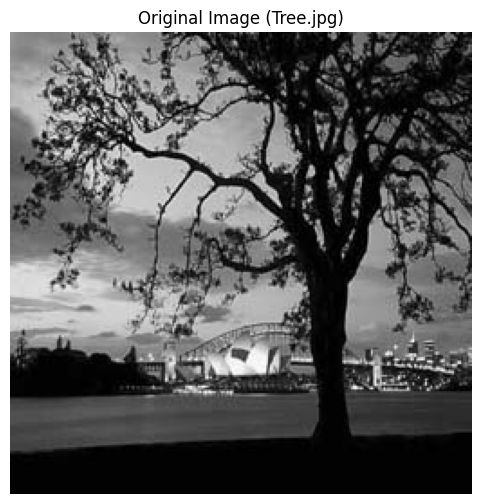

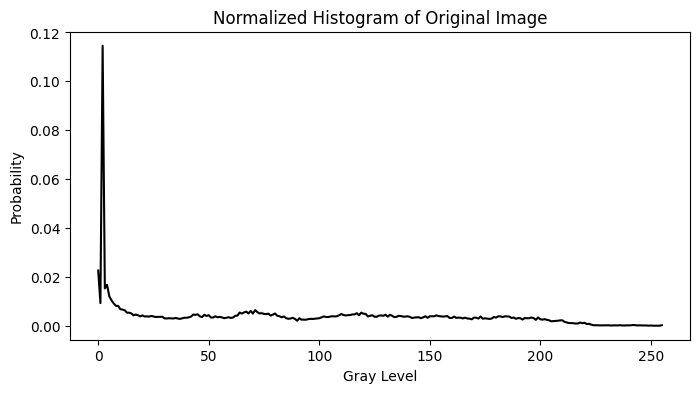

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load image
img = cv2.imread('Tree.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title('Original Image (Tree.jpg)')
plt.axis('off')
plt.show()

# Compute Histogram
hist = cv2.calcHist([img], [0], None, [256], [0,256])
hist_norm = hist / hist.sum()  # Normalize

plt.figure(figsize=(8,4))
plt.plot(hist_norm, color='black')
plt.title('Normalized Histogram of Original Image')
plt.xlabel('Gray Level')
plt.ylabel('Probability')
plt.show()



## Step 2: Perform Histogram Equalization
In this step, we use the cumulative distribution function to redistribute the intensity levels.

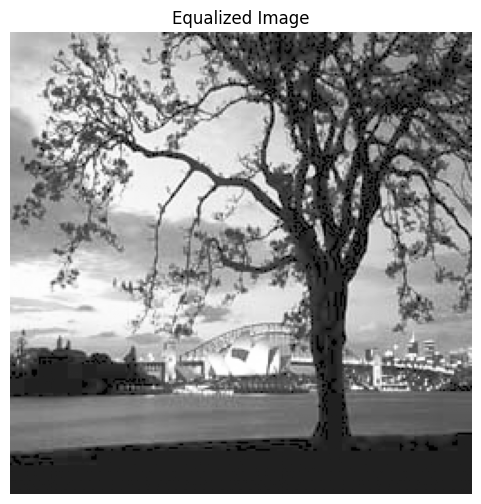

In [7]:
# Equalization
equalized = cv2.equalizeHist(img)

# Display the equalized image
plt.figure(figsize=(6,6))
plt.imshow(equalized, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')
plt.show()


## Step 3: Compare the Histogram of the Original and Equalized Image

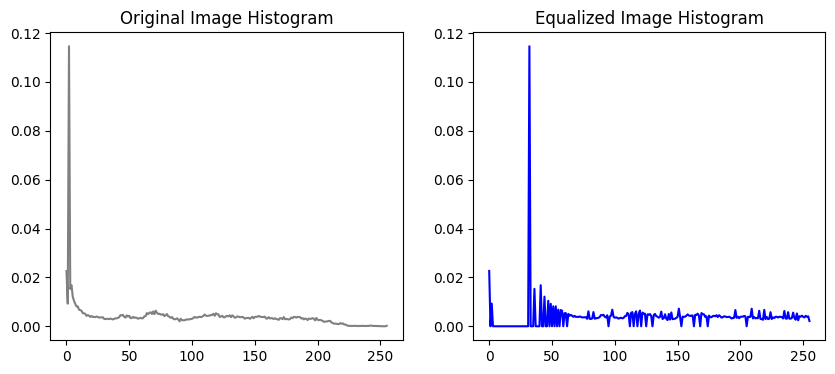

In [8]:
hist_eq = cv2.calcHist([equalized], [0], None, [256], [0,256])
hist_eq_norm = hist_eq / hist_eq.sum()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist_norm, color='gray')
plt.title('Original Image Histogram')
plt.subplot(1,2,2)
plt.plot(hist_eq_norm, color='blue')
plt.title('Equalized Image Histogram')
plt.show()


## Step 4: Compute Mean, Variance, Entropy, and PSNR

In [9]:
def entropy(image):
    hist = cv2.calcHist([image], [0], None, [256], [0,256])
    hist_norm = hist / hist.sum()
    hist_nonzero = hist_norm[hist_norm > 0]
    return -np.sum(hist_nonzero * np.log2(hist_nonzero))

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10((255**2) / mse)

# Original Image Metrics
mean_orig = np.mean(img)
var_orig = np.var(img)
entropy_orig = entropy(img)

# Equalized Image Metrics
mean_eq = np.mean(equalized)
var_eq = np.var(equalized)
entropy_eq = entropy(equalized)
psnr_val = psnr(img, equalized)

print("🔹Original Image:")
print(f"Mean: {mean_orig:.2f}  |  Variance: {var_orig:.2f}  |  Entropy: {entropy_orig:.4f}")
print("\n🔹Equalized Image:")
print(f"Mean: {mean_eq:.2f}  |  Variance: {var_eq:.2f}  |  Entropy: {entropy_eq:.4f}")
print(f"\nPSNR between the two images: {psnr_val:.2f} dB")


🔹Original Image:
Mean: 83.28  |  Variance: 4577.72  |  Entropy: 7.3086

🔹Equalized Image:
Mean: 126.81  |  Variance: 5300.35  |  Entropy: 7.1431

PSNR between the two images: 28.25 dB


## Step 5: Analyze the Results
Mean (μ): May change slightly since the overall brightness of the image is redistributed.
Variance (σ²): Usually increases because intensities are more spread out → higher contrast.
Entropy (H): Often increases as the information content (intensity diversity) becomes higher.
PSNR: Usually decreases slightly because Equalization modifies the image, but the difference is not drastic.

Conclusion:
Histogram Equalization increases contrast and provides a more uniform distribution of brightness, making details in dark and bright regions more visible.

---

# Section (2): Adaptive Histogram Equalization (AHE)

**Goal:**  
To compare different Adaptive Histogram Equalization methods for contrast enhancement in grayscale images with high local detail.

**Image:**  
We will use `Couple.tiff` with a size of 512×512 pixels.

**Approaches:**
1. **Tiling Approach** – Divide the image into blocks and apply local equalization.  
2. **Sliding Window Approach** – Use a moving window to locally equalize each region.

We will compute:
- **Entropy (H)** – Measures information content.  
- **PSNR (Peak Signal-to-Noise Ratio)** – Measures similarity to the original image.

Finally, we’ll analyze how window/block size affects image detail, contrast, and naturalness.


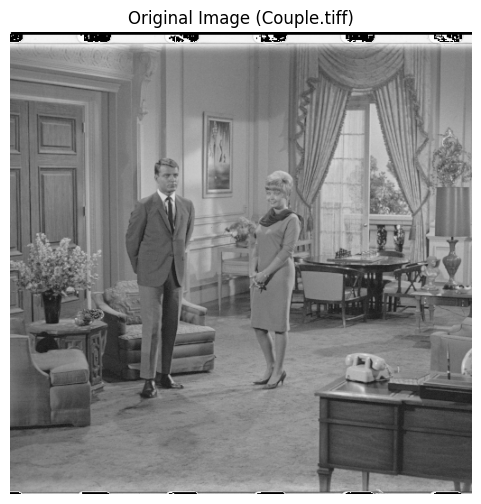

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image
img = cv2.imread('Couple.tiff', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (512, 512))

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title('Original Image (Couple.tiff)')
plt.axis('off')
plt.show()

In [3]:
def histogram_equalization_local(block):
    """Perform standard histogram equalization on a small image block."""
    hist = cv2.calcHist([block], [0], None, [256], [0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf[-1]  # normalize
    eq = np.interp(block.flatten(), range(256), 255 * cdf_normalized)
    return eq.reshape(block.shape).astype(np.uint8)

def entropy(image):
    """Compute entropy of the image."""
    hist = cv2.calcHist([image], [0], None, [256], [0,256])
    hist_norm = hist / hist.sum()
    hist_nonzero = hist_norm[hist_norm > 0]
    return -np.sum(hist_nonzero * np.log2(hist_nonzero))

def psnr(img1, img2):
    """Compute PSNR between two images."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10((255**2) / mse)

## Method 1: Tiling Approach

In this method, the image is divided into non-overlapping blocks (tiles),  
and each block is equalized independently.

We will test tile sizes of:
- 64×64
- 32×32
- 16×16


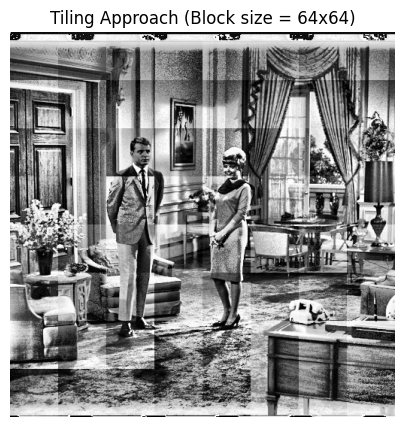

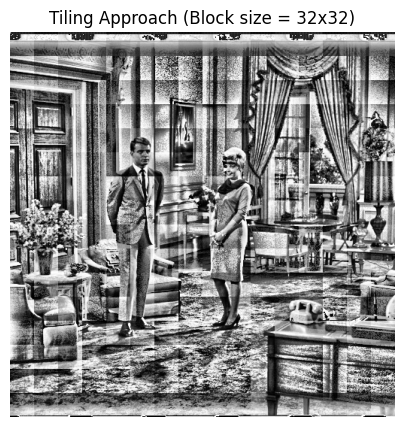

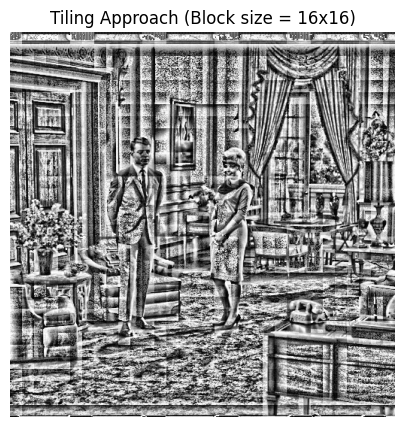

In [4]:
def adaptive_equalization_tiling(img, block_size):
    """Apply adaptive equalization using tiling approach."""
    h, w = img.shape
    result = np.zeros_like(img)
    
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = img[i:i+block_size, j:j+block_size]
            eq_block = histogram_equalization_local(block)
            result[i:i+block_size, j:j+block_size] = eq_block
    return result

block_sizes = [64, 32, 16]
tiling_results = {}

for b in block_sizes:
    eq_img = adaptive_equalization_tiling(img, b)
    tiling_results[b] = eq_img
    plt.figure(figsize=(5,5))
    plt.imshow(eq_img, cmap='gray')
    plt.title(f'Tiling Approach (Block size = {b}x{b})')
    plt.axis('off')
    plt.show()

## Method 2: Sliding Window Approach

In this method, a moving window scans across the image.  
For each pixel, histogram equalization is applied within the local window around it.

Window sizes to test:
- 64×64
- 32×32
- 16×16


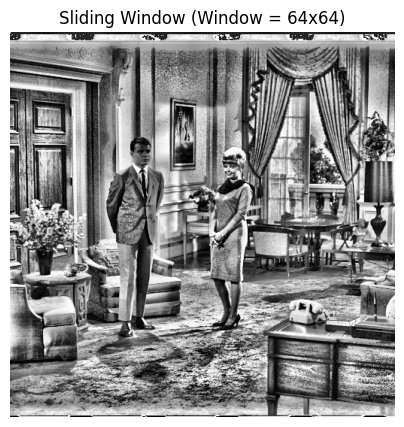

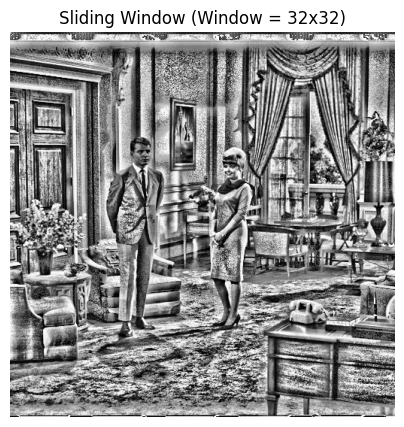

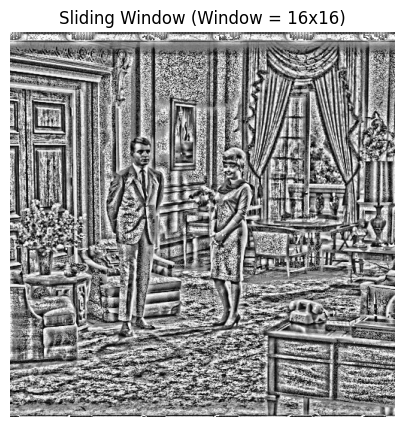

In [5]:
def adaptive_equalization_sliding(img, window_size):
    """Perform adaptive equalization using a sliding window."""
    pad = window_size // 2
    padded = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    result = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            local_region = padded[i:i+window_size, j:j+window_size]
            eq_pixel = histogram_equalization_local(local_region)[pad, pad]
            result[i, j] = eq_pixel
    return result

# This may take a few minutes for large images
sliding_results = {}
for w in block_sizes:
    eq_img = adaptive_equalization_sliding(img, w)
    sliding_results[w] = eq_img
    plt.figure(figsize=(5,5))
    plt.imshow(eq_img, cmap='gray')
    plt.title(f'Sliding Window (Window = {w}x{w})')
    plt.axis('off')
    plt.show()

## Metric Computation: Entropy and PSNR
Now we compute Entropy and PSNR for each image version (tiling & sliding).


In [6]:
def analyze_results(results, original):
    for size, img_res in results.items():
        h = entropy(img_res)
        p = psnr(original, img_res)
        print(f"Window/Block: {size}x{size} | Entropy = {h:.4f} | PSNR = {p:.2f} dB")

print("🔹 Tiling Approach Results:")
analyze_results(tiling_results, img)

print("\n🔹 Sliding Window Approach Results:")
analyze_results(sliding_results, img)

🔹 Tiling Approach Results:
Window/Block: 64x64 | Entropy = 7.9545 | PSNR = 27.82 dB
Window/Block: 32x32 | Entropy = 7.9807 | PSNR = 27.82 dB
Window/Block: 16x16 | Entropy = 7.9873 | PSNR = 27.85 dB

🔹 Sliding Window Approach Results:
Window/Block: 64x64 | Entropy = 7.9754 | PSNR = 27.86 dB
Window/Block: 32x32 | Entropy = 7.9760 | PSNR = 27.88 dB
Window/Block: 16x16 | Entropy = 7.9697 | PSNR = 27.85 dB


In [ ]:
def analyze_results(results, original):
    data = {"Block/Window Size": [], "Entropy": [], "PSNR": []}
    
    for size, img_res in results.items():
        h = entropy(img_res)
        p = psnr(original, img_res)
        data["Block/Window Size"].append(size)
        data["Entropy"].append(h)
        data["PSNR"].append(p)
    
    return data

tiling_data = analyze_results(tiling_results, img)
sliding_data = analyze_results(sliding_results, img)

import matplotlib.pyplot as plt

# Plot Entropy comparison
plt.figure(figsize=(8,5))
plt.plot(tiling_data["Block/Window Size"], tiling_data["Entropy"], 'o-', label="Tiling Approach")
plt.plot(sliding_data["Block/Window Size"], sliding_data["Entropy"], 's--', label="Sliding Window Approach")
plt.title("Entropy vs Block/Window Size")
plt.xlabel("Block/Window Size (pixels)")
plt.ylabel("Entropy")
plt.grid(True)
plt.legend()
plt.show()

# Plot PSNR comparison
plt.figure(figsize=(8,5))
plt.plot(tiling_data["Block/Window Size"], tiling_data["PSNR"], 'o-', label="Tiling Approach")
plt.plot(sliding_data["Block/Window Size"], sliding_data["PSNR"], 's--', label="Sliding Window Approach")
plt.title("PSNR vs Block/Window Size")
plt.xlabel("Block/Window Size (pixels)")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend()
plt.show()


## Comparative Analysis and Discussion

- **Entropy:**  
  Entropy tends to increase as the block/window size decreases.  
  Smaller regions enhance local contrast more, adding fine details.

- **PSNR:**  
  PSNR usually decreases with smaller windows because the image deviates more from the global intensity distribution.  
  However, visual contrast often improves.

- **Visual Observation:**  
  - Large tiles/windows → smoother, more natural appearance but less local contrast.  
  - Small tiles/windows → higher contrast but may introduce noise or unnatural effects.

### Summary:
| Method | Window/Block | Entropy ↑ | PSNR ↓ | Visual Effect |
|---------|--------------|-----------|---------|----------------|
| Global Equalization | — | Moderate | High | Global contrast improved |
| Tiling (32×32) | Medium | Higher | Slight drop | Good balance |
| Sliding (16×16) | Small | Highest | Lower | Strong local enhancement |

**Best Trade-off:**  
For natural images with rich local details (like `Couple.tiff`),  
the **Tiling Approach with 32×32 blocks** provides the best balance between contrast, entropy, and natural appearance.
